In [1]:
import itertools
import pandas as pd
import h5py 
from sklearn.manifold import TSNE
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize

In [2]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10,100]
    gammas = [0.001, 0.01, 0.1, 1,1e-1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [3]:
def rbf_kernel(X,Y):
    K=np.zeros((X.shape[0],Y.shape[0]))
    for x1,x2 in enumerate(X):
        for x3,x4 in enumerate(Y):
            K[x1,x3]= np.exp(-0.7*np.linalg.norm(x2-x4)**2)
    return K

In [4]:
def data_division(X,Y):
    train, test,train_label, test_label = train_test_split(X, Y, test_size=0.2, random_state=33)
    return train,train_label,test,test_label        

In [9]:
def onevsrest(X,Y,labels,foldsize,train_X,train_Y,test_X,test_Y,flag):
    param=svc_param_selection(X, Y,5)
    n_class=len(np.unique(Y))
    print(param)
    ans_arr=np.zeros((len(test_X),labels))
    crrct,wrng=0,0
    label1=0
    while label1<labels:
        model=svm.SVC(kernel=rbf_kernel,C=100,gamma=10)
        y=np.where(train_Y==label1,1,0)
        model.fit(train_X,y)
        ker=model.kernel
        spprt_vec=train_X[model.support_]
        dual_coef=model.dual_coef_
        intercpt=model.intercept_
        predicted=np.dot(dual_coef,ker(spprt_vec,test_X))+intercpt
        ans_arr[:,label1]=predicted
        label1=label1+1 
    p = np.argmax(ans_arr,axis=1)
    actu=pd.Series(test_Y,name='Correct')
    pred=pd.Series(p,name='Predicted')
    confusion_mat= pd.crosstab(actu,pred,rownames=['Correct'],colnames=['Predicted'])
    print(confusion_mat)
    plt.imshow(confusion_mat,interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(confusion_mat.columns))
    plt.xticks(tick_marks, confusion_mat.columns, rotation=45)
    plt.yticks(tick_marks, confusion_mat.index)
    for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
            plt.text(j,i,confusion_mat[i][j],horizontalalignment="center",color="black")

    plt.ylabel(confusion_mat.index.name)
    plt.xlabel(confusion_mat.columns.name)
    plt.tight_layout()
    plt.figure()
    plt.show()
    if(flag!=1):
        fpr,tpr,th = roc_curve(test_Y,p)
        roc_auc = auc(fpr,tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    else:
        y_score = test_Y
        y_binary = label_binarize(p, classes=[0, 1, 2]) 
        fpr = dict() 
        tpr = dict() 
        roc_auc = dict() 
        lw=2 
        for i in range(n_class): 
            fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_score) 
            print(fpr[i])
            roc_auc[i] = auc(fpr[i], tpr[i]) 
            fpr["micro"], tpr["micro"], _ = roc_curve(y_binary[:,i].ravel(), y_score.ravel()) 
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)])) 
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_class): 
            mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
        mean_tpr /= n_class
        fpr["macro"] = all_fpr 
        tpr["macro"] = mean_tpr 
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) 
        plt.figure() 
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4) 
        plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4) 
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue']) 
        for i,color in zip(range(n_class), colors): 
            plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i])) 
        plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
        plt.xlim([0.0, 1.0]) 
        plt.ylim([0.0, 1.05]) 
        plt.xlabel('False Positive Rate') 
        plt.ylabel('True Positive Rate') 
        plt.legend(loc="lower right")
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
    ax=None
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_dim = np.linspace(xlim[0], xlim[1], 30)
    y_dim= np.linspace(ylim[0], ylim[1], 30)
    Y_axis, X_axis = np.meshgrid(y_dim, x_dim)
    xy = np.vstack([X_axis.ravel(), Y_axis.ravel()]).T
    P = model.decision_function(xy).reshape(X_axis.shape)
    ax.contour(X_axis, Y_axis, P, colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
    ax.scatter(spprt_vec[:, 0],spprt_vec[:, 1],s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    a = accuracy_score(test_Y,p)
    print('Accuracy',a)
    print('F1-Score',f1_score(test_Y,p, average='macro') )
            
        
                            
                        


For DATASET 1
{'C': 0.01, 'gamma': 1}
Predicted   0  1
Correct         
0          12  0
1           0  8


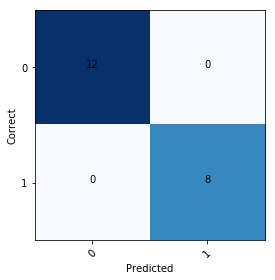

<Figure size 432x288 with 0 Axes>

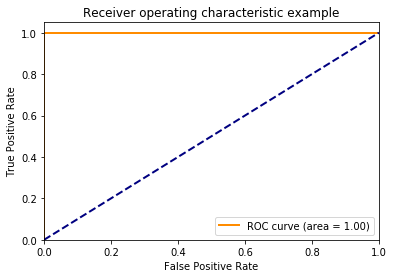

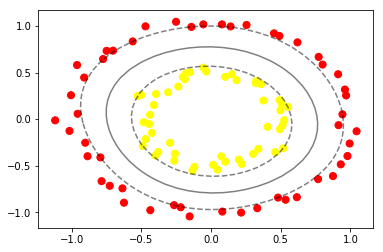

Accuracy 1.0
F1-Score 1.0

For DATASET 2
{'C': 1, 'gamma': 1}
Predicted   0   1
Correct          
0          10   0
1           0  10


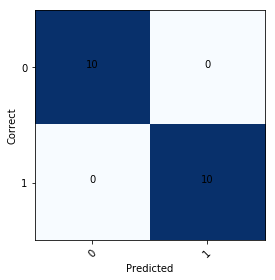

<Figure size 432x288 with 0 Axes>

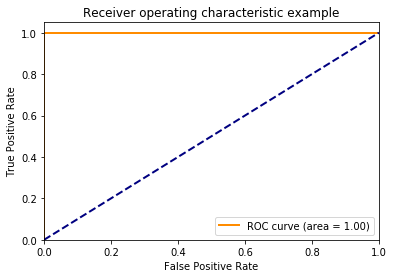

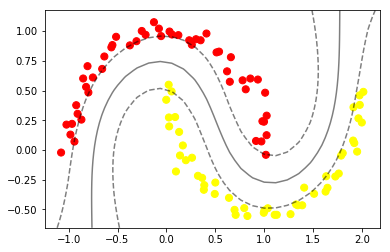

Accuracy 1.0
F1-Score 1.0

For DATASET 3


/Users/nikitamehrotra/Downloads/assignment1/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.1, 'gamma': 0.01}
Predicted  0   1  2
Correct            
0          3   0  0
1          0  11  0
2          0   0  6


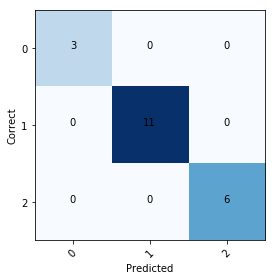

<Figure size 432x288 with 0 Axes>

[0.         0.35294118 1.         1.        ]
[0.         0.66666667 0.66666667 1.        ]
[0.         0.         0.78571429 1.        ]


/Users/nikitamehrotra/Downloads/assignment1/env/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


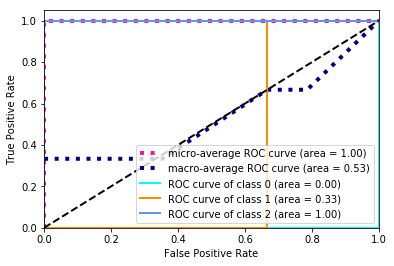

Accuracy 1.0
F1-Score 1.0

For DATASET 4
{'C': 100, 'gamma': 1}
Predicted    0    1
Correct            
0          180   18
1           23  179


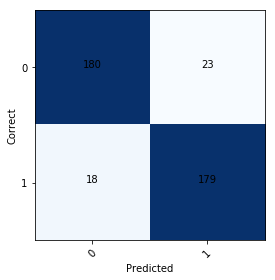

<Figure size 432x288 with 0 Axes>

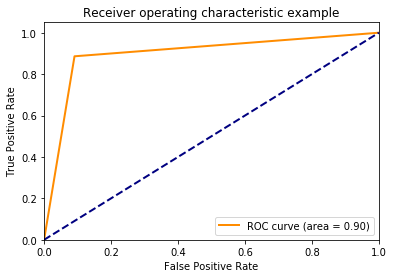

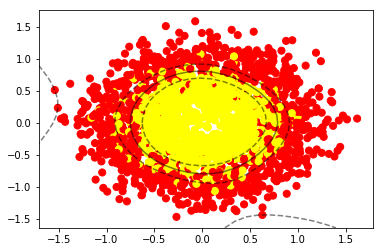

Accuracy 0.8975
F1-Score 0.8974993593709961


In [10]:
for i in range(0,4):
    j=i+1;
    flag=0
    print('\nFor DATASET',j)
    filename="data_"+str(j)+".h5"
    file=h5py.File(filename,'r');
    X=file.get('x')
    Y=file.get('y')
    X=np.array(X)
    Y=np.array(Y)
    labels=np.max(Y)+1
    foldsize=int(len(X)/5)
    train_X,train_Y,test_X,test_Y =data_division(X,Y)
    if(j!=3):
        onevsrest(X,Y,labels,foldsize,train_X,train_Y,test_X,test_Y,flag)
    else:
        flag=1
        onevsrest(X,Y,labels,foldsize,train_X,train_Y,test_X,test_Y,flag)
